In [1]:
!pip install exif

     |████████████████████████████████| 64 kB 3.6 MB/s 


In [2]:
import glob
from PIL import Image, UnidentifiedImageError
from PIL.ExifTags import TAGS #Dicionario chave/descricao dos metadatas padroes das imagens de formato jpg 
import exif

from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.applications.vgg16 import decode_predictions as decode_predictions_vgg

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
from keras.applications.inception_v3 import decode_predictions as decode_predictions_inception

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet 
from keras.applications.resnet50 import decode_predictions as decode_predictions_resnet

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenet
from keras.applications.mobilenet_v2 import decode_predictions as decode_predictions_mobilenet

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import copy

import matplotlib.pyplot as plt
import os
import sys

import numpy as np
import pandas as pd

from keras import backend

from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop

from google.colab import drive

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#Definicao do repertorio home do projet
#os.chdir("C:\\Users\\Utilisateur\\Downloads\\tmp\\MBA\\")
os.chdir('/content/drive/MyDrive/Colab Notebooks/MBA')
#Parametros
sizeImg = 128

In [5]:
#Lista de tags das 15 classes trabalhadas 
lstTagClas = ['arvore', 'ave', 'cachorro', 'caminhao', 'carro', 'casa', 'cavalo', \
              'gato', 'mar', 'montanha', 'ponte', 'praia', 'predio', 'rio', 'sol']
#Caso nao seja ainda feito, se ordena a lista por ordem alfabetico
lstTagClas.sort()
print(type(lstTagClas))
#Criacao do dicionario tag-id label das classes
dicTagId = {lstTagClas[idx]:idx for idx in range(len(lstTagClas))}
#Criacao do dicionario id-tag label das classes
dicIdTag = {idx:lstTagClas[idx] for idx in range(len(lstTagClas))}

countClasses = len(lstTagClas)
print(countClasses)


<class 'list'>
15


In [6]:
#Funcoes gerais para montar a lista de label de uma imagem (problema multi-label), codificar esta lista de label (gera o target da imagem),
# decodificar a target (gera a lista de label da imagem)

# Funcao para ter os tags de uma imagem a parte do nome do seu arquivo e da lista das classes trabalhadas
def getTagImg(nameFile, lstTagClas):
    #Recuperacao dos tags das classes trabalhadas do nome do arquivo
    lstTagImg = [tag for tag in nameFile.split('-') if tag in lstTagClas]
    #print(lstTagImg)
    return lstTagImg

# Funcao de codificaca do jogo de saida
def oneHotEncode(lstTagImg, dicTagId):
    '''Retorna um array de binary com 1 (classe presente) ou 0 (classe nao presente) para cada classe trabalhada, 
    na posicao definida pelo ID da classe'''
    #Criacao do array de tamanho do dicionario de mapping tag-id, inicializado a 0
    npIdImg = np.zeros(len(dicTagId), dtype=int)
    #Loop sobre a lista dos diferentes tags da imagem
    for tag in lstTagImg:
        #Se posiciona 1 na posicao do arry que corresponde ao ID do tag
        npIdImg[dicTagId[tag]] = 1
    #Se retorna o array de codificacao do jogo de saida da imagem
    return npIdImg

# Funcao de decodificaca do jogo de saida (target) en lista dos tags da foto
def oneHotDecode(tgt, dicIdTag):
    '''Retorna uma lista dos tags de ID correspondendo as posicoes do jogo de saida com 1'''
    #Recupera as posicoes preenchidas
    posId = np.nonzero(tgt)
    #Monta a lista dos tags da imagem
    lstTag = [dicIdTag[id] for id in posId[0]]
    #OBS: Precisa recuperar o indice 0 de posId prque np.nonzero retorna tuple de array de posicao nao 0, um elemento por dimensao do array
    return lstTag
    

In [7]:
#Funcao de carregamento e serializacao do jogo de entrada X (pixels das imagens) e de saida (one-hot encoding dos labels das imagens)
def loadImg(maskNameFile="*", sizeImg=128):
    # Criacao das listas com as imagens e com os labels
    lstImgs = []
    lstTgts = []
    lstNameFiles = []
    gntImages = glob.iglob(f"{maskNameFile}", recursive=False)
    #OBS: Pensar a regegar o generator que ficou vazio depois do loop que gerou o dico dos tags por imagem
    for pth in gntImages:
        try:
            #Se tratar-se bem de um arquivo
            if os.path.isfile(pth):
                nameFile = os.path.basename(pth)
                #print(nameFile)
                # Visualizacao da imagem sem transformacao
                #img = load_img(fr'{pth}')
                #plt.imshow(img)
                #plt.show()
                #plt.pause(1) 
                # Dados dos pixels desta imagem de tamanho limitado para economizar memoria
                img = image.load_img(fr'{pth}', target_size=(sizeImg,sizeImg))
                # convert to numpy array
                img = image.img_to_array(img)
                #OBS: No exemplo deep_learning_for_computer_vision.pdf, pagina 334, esta indicado de usar dtype uint8, mas como 
                #     o predict sobre os modelos pretreinados sem ajuste, nao foi bem succedido, se deixou os valores originais.
                # Target desta imagem
                lstTagImg = getTagImg(nameFile, lstTagClas)
                tgt = oneHotEncode(lstTagImg, dicTagId)
                #print(tgt)
                #Se uma das classes do projeto foi reconhecida a traves o nome do arquivo
                if (np.nonzero(tgt)[0].size > 0):
                    # Adicao da imagem, da target e do nome arquivo as listas
                    lstImgs.append(img)
                    lstTgts.append(tgt)
                    lstNameFiles.append(nameFile)
        except UnidentifiedImageError:
            print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque nao esta reconhecido como imagem.')
        except:
            print(nameFile)
            print("Unexpected error:", sys.exc_info()[0])
            raise
            
    #Se passa as imagens, as targets e nomes arquivo em array numpy
    X = np.asarray(lstImgs)
    Y = np.asarray(lstTgts, dtype=np.int8)
    npNameFiles = np.asarray(lstNameFiles)

    #Se salva estes arrays em um arquivo compressado de padrao numpy
    np.savez_compressed('XY_TestTransferLearning2.npz', X, Y, npNameFiles)  
    

In [8]:
#Se cria o arquivo de compressao com a mascara de imagem e o tamanho de imagens desejados
#OBS: A descomentar so na primeira execucao, ja que depois se pode ler diretamente do arquivo criado na primeira execucao
#loadImg("*", sizeImg)
#Se recarrega o jogo de entrada e saida a parte do arquivo de compressao numpy
data = np.load('XY_TestTransferLearning2.npz')
X, Y, npNameFiles = data['arr_0'], data['arr_1'], data['arr_2']
print(f'Loaded: X: {X.shape}, Y: {Y.shape}, npNameFiles: {npNameFiles.shape}\n')

#Se conta as imagens por classe estudada
print("Total imagens por classe estudada:")
print(pd.Series(data=Y.sum(axis=0), index=lstTagClas))
#Se aproveita do jogo de saida formada de uma serie de 15 booleans com 0 se nao a classe e 1 se tem a classe, para chegar
# ao total por classe, somando no axe dos rows (somando no axe de coluna, indicaria o total de tag por imagem).

#Stats do numero de classe por imagem
print("\nStats do total de classe estudada por imagem:")
print(pd.DataFrame(data=Y.sum(axis=1), columns=['Num. Classes']).describe())

#Se separa entre o jogo de treinamento e jogo de test
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.3, random_state=1)
print(XTrain.shape, YTrain.shape, XTest.shape, YTest.shape)


Loaded: X: (750, 128, 128, 3), Y: (750, 15), npNameFiles: (750,)

Total imagens por classe estudada:
arvore      301
ave          83
cachorro    104
caminhao     80
carro       179
casa        112
cavalo       91
gato         62
mar         173
montanha    111
ponte        94
praia       100
predio       87
rio         112
sol         114
dtype: int64

Stats do total de classe estudada por imagem:
       Num. Classes
count    750.000000
mean       2.404000
std        0.723982
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
(525, 128, 128, 3) (525, 15) (225, 128, 128, 3) (225, 15)


In [9]:
# Funcao de calculo da metrica Fbeta para uma classificacao multi-classe/label
#Se cria a metrica fbeta para avaliar o treinamento do modelo (se vai usar a principio com o beta 1 para ter usar a metrica F1)
#OBS: A funcao nativa foi retirada do keras devido a gerar confusao em funcao do calculo estar realizado ao nivel batch ou por metrica
#     A avaliar se a funcao copiada de deep_learning_for_computer_vision.pdf (pagina 335) esta adequada ou se precisa de uma funcao
#     mais sofisticada como explicada no pdf F-beta Score in Keras Part III. Creating custom F-beta score for… _ by Jolomi Tosanwumi _ Towards Data Science
def fBetaKeyras(YTrue, YPred, beta=1):
    # clip as predicoes entre 0 e 1 (inferior a 0 passa 0 e superior a 1 passa 1)
    YPred = backend.clip(YPred, 0, 1)
    # calcula os elementos que fazem parte do calculo do indicador FBeta
    tp = backend.sum(backend.round(backend.clip(YTrue * YPred, 0, 1)), axis=1)  #Verdadeiros Positivos
    fp = backend.sum(backend.round(backend.clip(YPred - YTrue, 0, 1)), axis=1)  #Falsos Positivos
    fn = backend.sum(backend.round(backend.clip(YTrue - YPred, 0, 1)), axis=1)  #Falsos Negativos
    # Calculo da acuracidade (precisao)
    p = tp / (tp + fp + backend.epsilon())
    # Calculo do recall
    r = tp / (tp + fn + backend.epsilon())
    # Calculo do FBeta, com a media de cada classe
    bb = beta ** 2
    fBetaScore = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    #OBS: Uso de uma constante infinitessima epsilon baixa para nao cair no erro de divisao por zero
        
    return fBetaScore


In [10]:
#Verificacao que esta implementacao especefica para Keyras da metrica fBeta da o mesmo resultado que a funcao equivalente de sklearn
beta=1 #Calculo da metria F1
# Se considera que todas as predicoes do jogo de treinamento e de teste acharam todas as classes em todas as imagens
YPredTrain = np.asarray([np.ones(YTrain.shape[1]) for _ in range(YTrain.shape[0])])
YPredTest = np.asarray([np.ones(YTest.shape[1]) for _ in range(YTest.shape[0])])
# Evaluacao do score F1 destas predicoes de 1 com sklearn
scoreTrain = fbeta_score(YTrain, YPredTrain, beta=beta, average='samples')
scoreTest = fbeta_score(YTest, YPredTest, beta=beta, average='samples')
print('All Ones (sklearn): train=%.4f, test=%.4f' % (scoreTrain, scoreTest))
# Evaluacao do score F1 destas predicoes de 1 com a funcao especefica implementada para uso com Keyras
scoreTrain = fBetaKeyras(backend.variable(YTrain), backend.variable(YPredTrain), beta=beta)
scoreTest = fBetaKeyras(backend.variable(YTest), backend.variable(YPredTest), beta=beta)
print('All Ones (keras): train=%.4f, test=%.4f' % (scoreTrain, scoreTest))

# Se considera que todas as predicoes do jogo de treinamento e de teste acharam nenhuma classe em todas as imagens
YPredTrain = np.asarray([np.zeros(YTrain.shape[1]) for _ in range(YTrain.shape[0])])
YPredTest = np.asarray([np.zeros(YTest.shape[1]) for _ in range(YTest.shape[0])])
# Evaluacao do score F1 destas predicoes de 1 com sklearn
scoreTrain = fbeta_score(YTrain, YPredTrain, beta=beta, average='samples')
scoreTest = fbeta_score(YTest, YPredTest, beta=beta, average='samples')
print('All Zeros (sklearn): train=%.4f, test=%.4f' % (scoreTrain, scoreTest))
# Evaluacao do score F1 destas predicoes de 1 com a funcao especefica implementada para uso com Keyras
scoreTrain = fBetaKeyras(backend.variable(YTrain), backend.variable(YPredTrain), beta=beta)
scoreTest = fBetaKeyras(backend.variable(YTest), backend.variable(YPredTest), beta=beta)
print('All Zeros (keras): train=%.4f, test=%.4f' % (scoreTrain, scoreTest))


All Ones (sklearn): train=0.2741, test=0.2714
All Ones (keras): train=0.2741, test=0.2714
All Zeros (sklearn): train=0.0000, test=0.0000
All Zeros (keras): train=0.0000, test=0.0000


In [11]:
#Funcao para apresentar a evoluca da funcao custo de perda e da metrica F1 por epoca de treinamento
def figureTrain(histTrain, nameFileFig):
    plt.figure(figsize=(8,7))
    # plot da funcao de custo de perda
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(histTrain.history['loss'], color='blue', label='train')
    plt.plot(histTrain.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('F1')
    plt.plot(histTrain.history['fBetaKeyras'], color='blue', label='train')
    plt.plot(histTrain.history['val_fBetaKeyras'], color='orange', label='test')
    plt.legend()
    
    plt.show()
    # Se salva a figura em arquivo
    plt.savefig(f'{nameFileFig}.png')
    plt.close()


In [ ]:
Tecnica early-stopping, quando o custo (loss) do jogo de teste comeca a subir e o do jogo train a seguir a baixar
(nao adianta seguir as epocas porque entrou na zona de over fitting) 

# II) MODELO INCEPTION PARA TRANSFER LEARNING
OBS: - Tentanto com o modelo Resnet50, tive um erro tentando colocar a camada flatten:
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor. resnet

      - Com MobileNet, os resultados se aproximam de os obtidos com Vgg16, usando o mesmo otimizador SGD com lr de 0,01, mas fica inferior.

In [13]:
# Modelo derivado do InceptionV3 para aplicar o transfer learning de toda a parte de selecao das features (parte convolucional do modelo)
# Drop out da camada convolucional passado de 0.2 a 0.1 para testar o data augmentation (um drop out demais forte junto com o data augmentation pode 
# impedir a aprendizagem)
def defineModelInceptionV3(inputShape, outputShape):
    # Se carrega o modelo da API Keyras
    #model = ResNet50(include_top=False, input_shape=inputShape, weights='imagenet')
    #model = MobileNetV2(include_top=False, input_shape=inputShape, weights='imagenet')
    model = InceptionV3(include_top=False, input_shape=inputShape, weights='imagenet')
    # Se indica que as camadas (ficou so as da parte convolucional de selecao das features) nao podem estar treinadas 
    # (para congelar os pesos recuperados do modelo Resnet)
    for camada in model.layers:
        camada.trainable = False
    # Se cria a parte de classificacao do modelo adicionando novas camadas densamente conectadas
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    drop1 = Dropout(0.1)(class1)
    output = Dense(outputShape, activation='sigmoid')(drop1)
    # Definicao do novo modelo
    model = Model(inputs=model.inputs, outputs=output)
    # Compilacao do modelo
    #opt = SGD(learning_rate=0.01, momentum=0.9)
    opt = RMSprop(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fBetaKeyras])
    # Apresentacao do modelo
    model.summary()
    return model

In [14]:
    # Se carrega o modelo da API Keyras
    input_shape=(sizeImg, sizeImg, 3)
    model = ResNet50(include_top=False, input_shape=inputShape, weights='imagenet')
    #model = InceptionV3(include_top=False, input_shape=inputShape, weights='imagenet')
    # Se indica que as camadas (ficou so as da parte convolucional de selecao das features) nao podem estar treinadas 
    # (para congelar os pesos recuperados do modelo Resnet)
    for camada in model.layers:
        camada.trainable = False
    # Se cria a parte de classificacao do modelo adicionando novas camadas densamente conectadas
    flat1 = Flatten()(model.layers[-1].output)

NameError: ignored

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
5/5 [==============================] - 70s 3s/step - loss: 5.4970 - fBetaKeyras: 0.1603 - val_loss: 2.5983 - val_fBetaKeyras: 0.2300
Epoch 2/200
5/5 [==============================] - 1s 139ms/step - loss: 2.6428 - fBetaKeyras: 0.2267 - val_loss: 1.9500 - val_fBetaKeyras: 0.2337
Epoch 3/200
5/5 [==============================] - 1s 155ms/step - loss: 2.0020 - fBetaKeyras: 0.2461 - val_loss: 1.6560 - val_fBetaKeyras: 0.2214
Epoch 4/200
5/5 [==============================] - 1s 138ms/step - loss: 1.4782 - fBetaKeyras: 0.2602 - val_loss: 1.2967 - val_fBetaKeyras: 0.2091
Epoch 5/200
5/5 [==============================] - 1s 152ms/step - loss: 1.2055 - fBetaKeyras: 0.2367 - val_loss: 1.1018 - val_fBetaKeyras: 0.2641
Epoch 6/200
5/5 [==============================] - 1s 130ms/step - loss: 0.9254 - fBetaKeyras: 0.2942 - val_loss: 1.1651 - val_fBetaKeyras: 0.2596
Epoch 7/200
5/5 [==============================] - 1s 130ms/step - loss: 0.8792 - fBetaKeyras: 0.3038 - val_loss: 0.9153

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


2/2 [==============================] - 0s 68ms/step - loss: 0.9274 - fBetaKeyras: 0.3136
> loss=0.927, fbeta=0.314


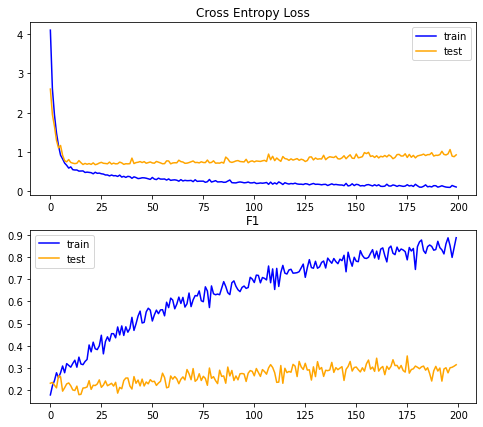

In [15]:
#Inicializacao do modelo InceptionV3, treinamento e avaliacao do resultado (com um dropout da camada convolucional a 0.2)
verbose=1

# Objeto Generator de Keyras com preprocessamento usando os valores centralizacao do jogo de dados de IMAGENET
dataGen = ImageDataGenerator(featurewise_center=True)
# Definicao da media do jogo de dados Imagenet para centralizacao das fotos como esperado pelo 
# modelo InceptionV3 treinado sobre este jogo
dataGen.mean = [123.68, 116.779, 103.939]

# Criacao dos objetos de iteracao do jogo de treinamento e de teste para gerar batch das imagens a cada epoca do treinamento
iterTrain = dataGen.flow(XTrain, YTrain, batch_size=128)
iterTest = dataGen.flow(XTest, YTest, batch_size=128)
# Definicao do modelo RENET50
# Aplicacao da tecnica de machine learning ja que o treinamento vai se limitar a parte de classificacao (camadas densamente
# conectadas), aproveitando na parte de selecao das features (camadas convolucionais e de pooling) dos pesos ja treinados 
# com o jogo de dados Imagenet.
model = defineModelInceptionV3((sizeImg, sizeImg, 3), countClasses)
# Treinamento (fit) do modelo
histTrain = model.fit_generator(iterTrain, steps_per_epoch=len(iterTrain), \
                                validation_data=iterTest, validation_steps=len(iterTest), epochs=200, verbose=verbose)
# Evaluacao do modelo
loss, fBeta = model.evaluate_generator(iterTest, steps=len(iterTest), verbose=verbose)
print('> loss=%.3f, fbeta=%.3f' % (loss, fBeta))
# Figura com as curvas de treinamento
figureTrain(histTrain, 'INCEPTIONV3')


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 63, 63, 32)   864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_752 (BatchN (None, 63, 63, 32)   96          conv2d_752[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 63, 63, 32)   0           batch_normalization_752[0][0]    
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


2/2 [==============================] - 0s 70ms/step - loss: 0.4682 - fBetaKeyras: 0.2020
> loss=0.468, fbeta=0.202


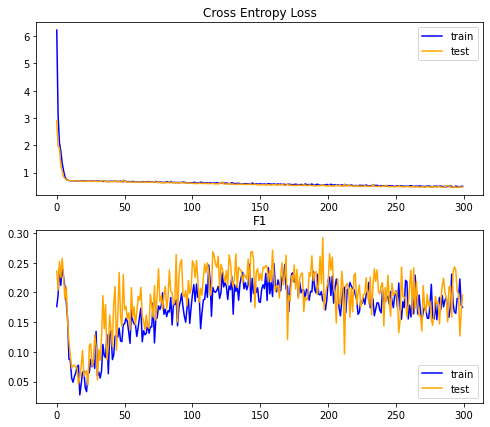

In [ ]:
#Inicializacao do modelo INCEPTIONV3, treinamento COM DATA AUGMENTATION e avaliacao do resultado (com um dropout da camada convolucional baixado a 0.1)
verbose=1

#Multiplica o numero de etapa para finalizar uma epoca (se espera que todas as imagens foram lidas a cada epoca para aproveitar ao maximo
# do jogo de treinamento).
# Ao final de cada etapa se executa o calculo da funcao de perda sobre o batch de imagem, aplicando a backpropagacao do erro para ajustar os pesos, 
# antes de iniciar a proxima etapa.
# Como a tecnica de data augmentation, permite ao generator do batch size de treinamento de estar em teoria infinito, se multiplica o tamanho do
# iterator de treinamento (igual ao trunc por encima do total imagem do jogo dividido pelo batch size) pelo parametro abaixo, para tentar aproveitar
# do dataaumentation sobre todo o jogo de imagem original.
# Por padrao, se informa este parametro com o numero de tecnicas de data augmentation, indicado no objeto generator do jogo de treinamento.
# Nao precisa augmentar o numero de etapa sobre o jogo de validacao, porque nao se aplica a tecnica de date augmentation sobre este jogo.
numMultStepEpoc=3
#OBS: Nao funciona conforme esperado e precisa deixar o parametro a 1 senao tem o erro "WARNING:tensorflow:Your input ran out of data; interrupting training."
# Pesquisa no Internet indicando que se aproveita do data augmenetion de uma epoca para outra (entretanto aumentar param epoca em vez param step), 
# mas fica a duvida se realmente a cada epoca, o generator gera a mesma quantidade de imagem com transformacao diferente
# https://stackoverflow.com/questions/61918148/input-ran-out-of-data-interrupting-training 
# https://stackoverflow.com/questions/63713904/data-augmentation-with-keras-running-out-of-data
#Under the hood it returns a tf.data.Dataset which does not run indefinitely. The transformations are applied randomly. It's not new images that are created indefinitely. 
#But that's just how keras is made. In previous versions you didn't have to specify these arguments
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
#-> Param a usar para multiplicar o numero de epoca em vez do numero de step

# Objeto Generator de Keyras com preprocessamento usando os valores centralizacao do jogo de dados de IMAGENET
# No caso do generator usado coom o jogo de treinamento, se aplica distorcoes da foto para aplicar a tecnica de data augmentatin
#Parametros usados no livro Deep Learning with Python
dictArgDataAugm = {'rotation_range':40, 'width_shift_range':0.2, 'height_shift_range':0.2, 'shear_range':0.2, \
                   'zoom_range':0.2, 'horizontal_flip':True, 'fill_mode':'nearest'}
dataGenTrain = ImageDataGenerator(featurewise_center=True, **dictArgDataAugm)


dataGenTest = ImageDataGenerator(featurewise_center=True)
# Definicao da media do jogo de dados Imagenet para centralizacao das fotos como esperado pelo modelo VGG16 treinado sobre este jogo
dataGenTrain.mean = [123.68, 116.779, 103.939]
dataGenTest.mean = [123.68, 116.779, 103.939]
# Criacao dos objetos de iteracao do jogo de treinamento e de teste para gerar batch das imagens a cada epoca do treinamento
iterTrain = dataGenTrain.flow(XTrain, YTrain, batch_size=128)
iterTest = dataGenTest.flow(XTest, YTest, batch_size=128)

# O resto do codigo esta parecido ao de treinamento do modelo VGG base e poderia estar passado em uma funcao 
# (menos o numero de epoca que pode estar menor que para o treinamento base, visto que se treina so a parte de classificacao)

# Definicao do modelo INCEPTIONV3
# Aplicacao da tecnica de machine learning ja que o treinamento vai se limitar a parte de classificacao (camadas densamente
# conectadas), aproveitando na parte de selecao das features (camadas convolucionais e de pooling) dos pesos ja treinados 
# com o jogo de dados Imagenet.
model = defineModelInceptionV3((sizeImg, sizeImg, 3), countClasses)
# Treinamento (fit) do modelo
histTrain = model.fit(iterTrain, steps_per_epoch=len(iterTrain), \
                                validation_data=iterTest, validation_steps=len(iterTest), epochs=100*numMultStepEpoc, verbose=verbose)
#OBS: fit_generator esta depreciado. Se usa agora fit que foi adequado para funcionar com generator para os parametros de jogo de treinamento/test.
# Evaluacao do modelo
loss, fBeta = model.evaluate_generator(iterTest, steps=len(iterTest), verbose=verbose)
print('> loss=%.3f, fbeta=%.3f' % (loss, fBeta))
# Figura com as curvas de treinamento
figureTrain(histTrain, 'InceptionV3DataAugm')
